# Experiment Ten

## Analysis

In [1]:
%load_ext pycodestyle_magic

In [11]:
# Analytical Tools
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

# General Utilities
import json
import pprint
import random

# Custom Utilities
import utilities.processing as processing
import utilities.plotting as plotting
import utilities.describe as describe

# Some settings
log = pprint.pprint
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Reading Data and Defining Constants

In [12]:
FILE_NAMES = [
    'raw-data/survey-ten-responses.json',
]

CONDITIONS = ['Quiz', 'Up-votes']
QUESTIONS = ['Curiosity']

NUM_JUDGEMENTS = 1
NUMBER_OF_GROUPS = 2
GROUP_SIZE = 2
ALL_LABELS = processing.get_article_labels(NUMBER_OF_GROUPS, GROUP_SIZE)
JUDGMENT_LABELS = processing.get_judgment_labels(NUM_JUDGEMENTS)

OTHER_LABELS = ALL_LABELS[:GROUP_SIZE]
SCIENCE_LABELS = ALL_LABELS[GROUP_SIZE:]

In [8]:
quiz_responses = pd.read_pickle('raw-data/quiz-responses.pkl')
upvote_responses = pd.read_pickle('raw-data/upvote-responses.pkl')

upvote_responses.head()

,condition_number,consent,g0_i0_j0,g0_i0_number,g0_i0_time,g0_i1_j0,g0_i1_number,g0_i1_time,g1_i0_j0,g1_i0_number,g1_i0_time,g1_i1_j0,g1_i1_number,g1_i1_time,high_group,participant_id,quiz_one,quiz_two,response_type
34,1,1.0,5.0,5.0,24386.0,3.0,6.0,4942.0,1.0,9112.0,25309.0,1.0,9565.0,4691.0,1,bavwt1kyppsqpl0rkuo3lv8hvsemoz11,1.0,1.0,0
47,1,1.0,0.0,6.0,15338.0,0.0,6.0,25815.0,2.0,8921.0,6153.0,4.0,8716.0,42526.0,1,ugj5bagsh00kpjltkk49g0r1ksagk910,1.0,1.0,0
50,1,1.0,5.0,6.0,36101.0,2.0,4.0,29804.0,1.0,8803.0,36141.0,3.0,9351.0,19342.0,1,73vbagummagw9qga2jhx4nx9k86o2jaz,1.0,1.0,0
53,1,1.0,1.0,5.0,2948.0,4.0,4.0,12791.0,4.0,10012.0,19606.0,5.0,8525.0,38386.0,1,ne4b0fgkk9l0pylv46j880p926rzl8f0,1.0,1.0,0
55,1,1.0,0.0,5.0,24855.0,0.0,4.0,3608.0,5.0,8697.0,108334.0,0.0,9316.0,17039.0,1,vv0tlvo8ygv58g6c2zmeo86toed5rzgk,0.0,1.0,0


### Intragroup Low/High Rating T-Tests

In [13]:
for data in (quiz_responses, upvote_responses):
    for j_label in JUDGMENT_LABELS:
        other_headers = ['{}_{}'.format(q_label, j_label) for q_label in OTHER_LABELS]
        science_headers = ['{}_{}'.format(q_label, j_label) for q_label in SCIENCE_LABELS]
        
        other_data = data[other_headers].mean(axis=1)
        science_data = data[science_headers].mean(axis=1)
        
        data['{}_other'.format(j_label)] = other_data
        data['{}_science'.format(j_label)] = science_data
        data['{}_diff'.format(j_label)] = science_data - other_data

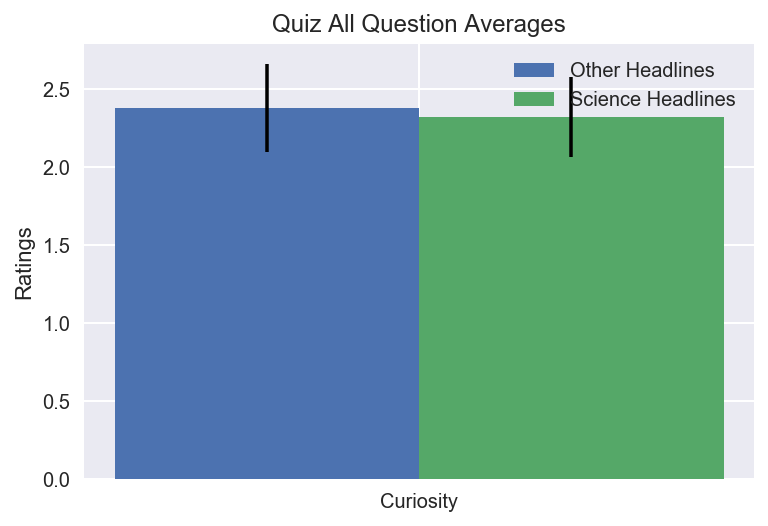

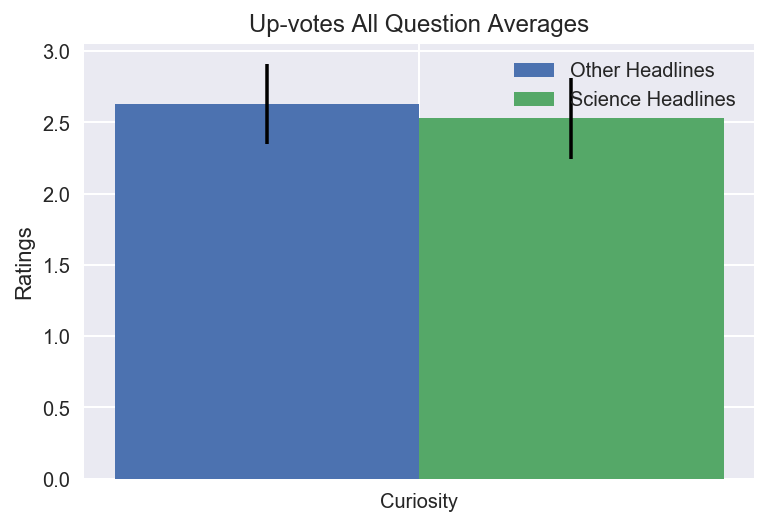

,condition_number,consent,g0_i0_j0,g0_i0_number,g0_i0_time,g0_i1_j0,g0_i1_number,g0_i1_time,g1_i0_j0,g1_i0_number,...,g1_i1_number,g1_i1_time,high_group,participant_id,quiz_one,quiz_two,response_type,j0_other,j0_science,j0_diff
34,1,1.0,5.0,5.0,24386.0,3.0,6.0,4942.0,1.0,9112.0,...,9565.0,4691.0,1,bavwt1kyppsqpl0rkuo3lv8hvsemoz11,1.0,1.0,0,4.0,1.0,-3.0
47,1,1.0,0.0,6.0,15338.0,0.0,6.0,25815.0,2.0,8921.0,...,8716.0,42526.0,1,ugj5bagsh00kpjltkk49g0r1ksagk910,1.0,1.0,0,0.0,3.0,3.0
50,1,1.0,5.0,6.0,36101.0,2.0,4.0,29804.0,1.0,8803.0,...,9351.0,19342.0,1,73vbagummagw9qga2jhx4nx9k86o2jaz,1.0,1.0,0,3.5,2.0,-1.5
53,1,1.0,1.0,5.0,2948.0,4.0,4.0,12791.0,4.0,10012.0,...,8525.0,38386.0,1,ne4b0fgkk9l0pylv46j880p926rzl8f0,1.0,1.0,0,2.5,4.5,2.0
55,1,1.0,0.0,5.0,24855.0,0.0,4.0,3608.0,5.0,8697.0,...,9316.0,17039.0,1,vv0tlvo8ygv58g6c2zmeo86toed5rzgk,0.0,1.0,0,0.0,2.5,2.5


In [19]:
PLOTTING_OPTIONS = {
    'ylabel': 'Ratings',
    'ticks': ['Curiosity'],
    'legend': ['Other Headlines', 'Science Headlines'],
}

for name, data in zip(CONDITIONS, (quiz_responses, upvote_responses)):
    other_means, other_errs = [], []
    science_means, science_errs = [], []
    
    for j_label in JUDGMENT_LABELS:
        other_data = data['{}_other'.format(j_label)]
        science_data = data['{}_science'.format(j_label)]
        other_means.append(other_data.mean())
        science_means.append(science_data.mean())
        other_errs.append(stats.sem(other_data))
        science_errs.append(stats.sem(science_data))
        
    plotting.plot_double_bar(other_means, other_errs, science_means, science_errs,
        **PLOTTING_OPTIONS, title='{} All Question Averages'.format(name))

In [22]:
for name, data in zip(CONDITIONS, (quiz_responses, upvote_responses)):
    print('{}'.format(name))
    for question, j_label in zip(QUESTIONS, JUDGMENT_LABELS):
        print('{}: {}'.format(question, describe.paired_t_test(
            data['{}_other'.format(j_label)], data['{}_science'.format(j_label)])))
    print()

Quiz
Curiosity: t = 0.172, p = 0.864 (0 greater)

Up-votes
Curiosity: t = 0.311, p = 0.758 (0 greater)



### Intergroup Difference T-Tests

In [25]:
print('Quiz & Post Upvotes')
for question, j_label in zip(QUESTIONS, JUDGMENT_LABELS):
    print('{}: {}'.format(question, describe.independent_t_test(
        quiz_responses['{}_diff'.format(j_label)],
        upvote_responses['{}_diff'.format(j_label)])))

Quiz & Post Upvotes
Curiosity: t = 0.0975, p = 0.923 (0 greater)


In [26]:
for data in (quiz_responses, upvote_responses):
    other_headers = ['{}_time'.format(q_label) for q_label in OTHER_LABELS]
    science_headers = ['{}_time'.format(q_label) for q_label in SCIENCE_LABELS]
        
    other_data = data[other_headers].mean(axis=1)
    science_data = data[science_headers].mean(axis=1)
    data['time_diff'.format(j_label)] = science_data - other_data

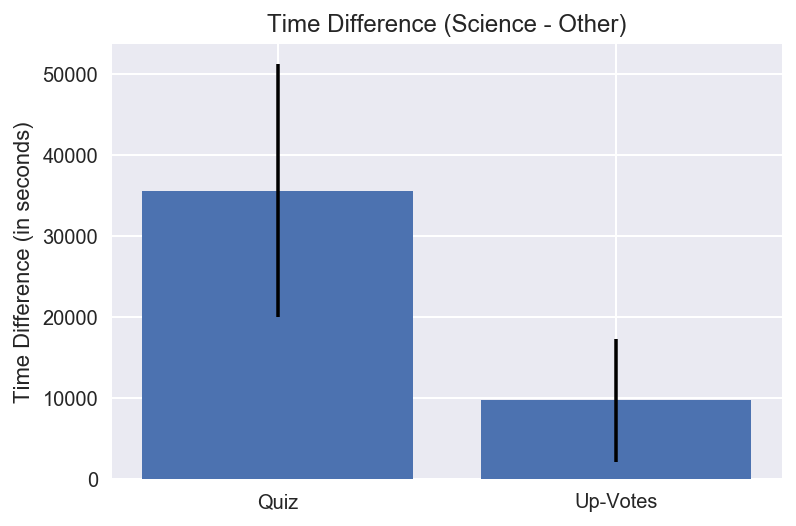

In [30]:
PLOTTING_OPTIONS = {
    'ylabel': 'Time Difference (in seconds)',
    'ticks': ['Quiz', 'Up-Votes'],
    'title': 'Time Difference (Science - Other)',
}

plotting.plot_single_bar(
    [quiz_responses.time_diff.mean(),
     upvote_responses.time_diff.mean()],
    [stats.sem(quiz_responses.time_diff),
     stats.sem(upvote_responses.time_diff)],
    **PLOTTING_OPTIONS
)

In [27]:
print('{}: {}'.format(question, describe.independent_t_test(
        quiz_responses['time_diff'], upvote_responses['time_diff'])))

Curiosity: t = 1.48, p = 0.145 (0 greater)
